In [7]:
import torch
from dataset import Planetoid
import os.path as osp
import torch_geometric.transforms as T
import numpy as np

from torch_geometric.nn import GCNConv
import torch.nn as nn
import torch.nn.functional as F
from aug import augment_GRACE, augment_CCA
from torch_geometric.utils import add_self_loops
from utils.utils import *
import random

name = 'PubMed'
path = osp.join('datasets', name)
split = 'imbalance'
imb_ratio = 10
fix_minority = True
model_name = 'GRACE'
dataset = Planetoid(path, name, split=split, imb_ratio= imb_ratio, fix_minority= fix_minority, transform = T.NormalizeFeatures())
data = dataset[0]

## Train GRACE

In [24]:
config_citeseer = {
  'use_seed': False,
  'add_self_loops': False,
  'seed': 38108,
  'learning_rate': 0.001,
  'hid_dim': 256,
  'proj_hidden_dim': 256,
  'activation': 'prelu',
  'base_model': 'GCNConv',
  'num_layers': 2,
  'drop_edge_rate_1': 0.2,
  'drop_edge_rate_2': 0.0,
  'drop_feature_rate_1': 0.3,
  'drop_feature_rate_2': 0.2,
  'tau': 0.9,
  'num_epochs': 200,
  'weight_decay': 0.00001,
  'BalanceMLP':{
    'epochs': 2000,
    'lr': 0.01,
    'weight_decay': 0.000005,
    'dropout': 0.5,
    'num_proj_layers': 1,
    'proj_hid_dim': 64}
}
torch.manual_seed(config_citeseer['seed'])
random.seed(12345)
from SSL.GRACE import Encoder, Model
encoder = Encoder(dataset.num_features, config_citeseer['hid_dim'], activation=({'relu': F.relu, 'prelu': nn.PReLU()})[config_citeseer['activation']],
                base_model=({'GCNConv': GCNConv})[config_citeseer['base_model']], k=config_citeseer['num_layers']).cuda()
model = Model(encoder, config_citeseer['proj_hidden_dim'], config_citeseer['proj_hidden_dim'], config_citeseer['tau']).cuda()
optimizer = torch.optim.Adam(
    model.parameters(), lr=config_citeseer['learning_rate'], weight_decay=config_citeseer['weight_decay'])

data = data.cuda()

In [25]:
for epoch in range(1, config_citeseer['num_epochs'] + 1):
    model.train()
    optimizer.zero_grad()
    x = data.x
    edge_index = data.edge_index
    edge_index_1, edge_index_2, x_1, x_2 = augment_GRACE(config_citeseer, x, edge_index)
    if config_citeseer['add_self_loops']:
        edge_index_1 = add_self_loops(edge_index_1)[0]
        edge_index_2 = add_self_loops(edge_index_2)[0]
    z1 = model(x_1, edge_index_1)
    z2 = model(x_2, edge_index_2)
    loss = model.loss(z1, z2, batch_size=0)
    loss.backward()
    optimizer.step()
    print(f'(T) | Epoch={epoch:03d}, loss={loss:.4f}')

(T) | Epoch=001, loss=8.8028
(T) | Epoch=002, loss=8.8027
(T) | Epoch=003, loss=8.8026
(T) | Epoch=004, loss=8.8021
(T) | Epoch=005, loss=8.8007
(T) | Epoch=006, loss=8.7959
(T) | Epoch=007, loss=8.7834
(T) | Epoch=008, loss=8.7504
(T) | Epoch=009, loss=8.6763
(T) | Epoch=010, loss=8.5257
(T) | Epoch=011, loss=8.4098
(T) | Epoch=012, loss=8.4094
(T) | Epoch=013, loss=8.4352
(T) | Epoch=014, loss=8.3654
(T) | Epoch=015, loss=8.3258
(T) | Epoch=016, loss=8.2479
(T) | Epoch=017, loss=8.2194
(T) | Epoch=018, loss=8.2117
(T) | Epoch=019, loss=8.1711
(T) | Epoch=020, loss=8.1693
(T) | Epoch=021, loss=8.1731
(T) | Epoch=022, loss=8.1324
(T) | Epoch=023, loss=8.1177
(T) | Epoch=024, loss=8.1105
(T) | Epoch=025, loss=8.0942
(T) | Epoch=026, loss=8.0895
(T) | Epoch=027, loss=8.0685
(T) | Epoch=028, loss=8.0510
(T) | Epoch=029, loss=8.0419
(T) | Epoch=030, loss=8.0370
(T) | Epoch=031, loss=8.0106
(T) | Epoch=032, loss=7.9977
(T) | Epoch=033, loss=7.9978
(T) | Epoch=034, loss=7.9755
(T) | Epoch=03

In [26]:
# test
model.eval()
z = model(x, edge_index)
z = z.detach().cpu()
save_embeddings(z, path=osp.join('embeddings', name + '_' + model_name+'.pt'))

Saved.


In [27]:
z = load_embeddings(osp.join('embeddings', name + '_' + model_name+'.pt'))
from balance import balance_embedding_mean_cls, balance_embedding_assign, BalanceMLP
from sklearn.metrics import f1_score, balanced_accuracy_score
from eval import label_classification

n_cls   = dataset.num_classes
balanced_mlp = BalanceMLP(config_citeseer, z.shape[1], n_cls).cuda()
optimizer_mlp = torch.optim.Adam(balanced_mlp.parameters(), 
                                 lr=config_citeseer['BalanceMLP']['lr'], 
                                 weight_decay=config_citeseer['BalanceMLP']['weight_decay'])
loss_func_mlp = nn.CrossEntropyLoss()

imb_train_masks = data.imb_train_masks
imb_train_mask = imb_train_masks[7]
data.imb_train_mask = imb_train_mask

balanced_data = balance_embedding_assign(dataset, data, z, n_cls, metric='inner_product')
data = balanced_data



train_mask = data.imb_train_mask
new_y = data.new_y
# new_y = data.y

y     = data.y
best_val_f1 = 0
best_test_acc, best_test_f1,best_test_bacc= 0, 0, 0
best_val_epoch = -1
# label_classification(args, data, z, ratio=0.1)


In [28]:
for e in range(config_citeseer['BalanceMLP']['epochs']):
    balanced_mlp.train()
    optimizer_mlp.zero_grad()
    x = z.cuda()
    new_y = new_y.cuda()
    train_mask = train_mask.cuda()
    logits = balanced_mlp(x)
    loss_mlp = loss_func_mlp(logits[train_mask], new_y[train_mask])  # 利用伪训练集标签训练分类器
    loss_mlp.backward()
    optimizer_mlp.step()
    with torch.no_grad():
        balanced_mlp.eval()
        val_mask  = data.val_mask.cuda()
        y         = data.y.cuda()
        test_mask = data.test_mask.cuda()
        preds = balanced_mlp(x).argmax(dim = -1)

        y_val = y[val_mask].detach().cpu().numpy()
        y_test = y[test_mask].detach().cpu().numpy()
        val_preds = preds[val_mask].detach().cpu().numpy()
        test_preds  = preds[test_mask].detach().cpu().numpy()

        acc_val = f1_score(y_val, val_preds, average='micro')
        f1_val      = f1_score(y_val, val_preds, average='macro')
        bacc_val    = balanced_accuracy_score(y_val, val_preds)
        acc_test    = f1_score(y_test, test_preds, average='micro')
        f1_test     = f1_score(y_test, test_preds, average='macro')
        bacc_test    = balanced_accuracy_score(y_test, test_preds)
        if f1_val >= best_val_f1:
            best_val_epoch = e
            best_val_f1 = f1_val
            best_test_acc = acc_test
            best_test_f1  = f1_test
            best_test_bacc = bacc_test
    print("<Epoch %d> [Val Acc] %.4f [Val F1] %.4f [Val bacc] %.4f <Best Val:> [Epoch] %d <Test:> [Test Acc] %.4f [Test F1] %.4f [Test bacc] %.4f" % (
        epoch, acc_val,f1_val,bacc_val, best_val_epoch, best_test_acc, best_test_f1, best_test_bacc
    ))
print("[Test Acc] %.4f [Test F1] %.4f [Test bacc] %.4f" % (best_test_acc, best_test_f1, best_test_bacc)) 

<Epoch 200> [Val Acc] 0.2020 [Val F1] 0.1048 [Val bacc] 0.2293 <Best Val:> [Epoch] 0 <Test:> [Test Acc] 0.2330 [Test F1] 0.1153 [Test bacc] 0.2298
<Epoch 200> [Val Acc] 0.2420 [Val F1] 0.1419 [Val bacc] 0.2659 <Best Val:> [Epoch] 1 <Test:> [Test Acc] 0.2640 [Test F1] 0.1468 [Test bacc] 0.2588
<Epoch 200> [Val Acc] 0.2980 [Val F1] 0.2264 [Val bacc] 0.3219 <Best Val:> [Epoch] 2 <Test:> [Test Acc] 0.3180 [Test F1] 0.2321 [Test bacc] 0.3149
<Epoch 200> [Val Acc] 0.3380 [Val F1] 0.2910 [Val bacc] 0.3720 <Best Val:> [Epoch] 3 <Test:> [Test Acc] 0.3410 [Test F1] 0.2693 [Test bacc] 0.3424
<Epoch 200> [Val Acc] 0.3760 [Val F1] 0.3255 [Val bacc] 0.4049 <Best Val:> [Epoch] 4 <Test:> [Test Acc] 0.3740 [Test F1] 0.3179 [Test bacc] 0.3868
<Epoch 200> [Val Acc] 0.3980 [Val F1] 0.3505 [Val bacc] 0.4335 <Best Val:> [Epoch] 5 <Test:> [Test Acc] 0.3760 [Test F1] 0.3272 [Test bacc] 0.3960
<Epoch 200> [Val Acc] 0.3980 [Val F1] 0.3517 [Val bacc] 0.4364 <Best Val:> [Epoch] 6 <Test:> [Test Acc] 0.3820 [Test F

In [29]:
train_labels = data.y[imb_train_mask]
train_idx = imb_train_mask.nonzero().flatten()

In [30]:
minority_nodes = train_idx[(train_labels >= n_cls//2)]

In [31]:
minority_nodes

tensor([ 8, 21, 26, 47, 61, 97], device='cuda:0')

In [58]:
labels[minority_nodes.detach().cpu().numpy()]

array([3, 5, 5, 4, 3, 4])

In [32]:
z

tensor([[ 0.0029,  0.0077,  0.0325,  ...,  0.0560,  0.0031, -0.0068],
        [-0.0026,  0.0177,  0.0126,  ..., -0.0015,  0.0069, -0.0058],
        [ 0.0378,  0.0386,  0.0264,  ...,  0.0074, -0.0023,  0.0123],
        ...,
        [-0.0023, -0.0005,  0.0172,  ...,  0.0362,  0.0100, -0.0071],
        [ 0.0331,  0.0399, -0.0037,  ..., -0.0106,  0.0031,  0.0006],
        [ 0.0185,  0.0331, -0.0010,  ..., -0.0027,  0.0029,  0.0137]])

In [54]:
from sklearn.manifold import TSNE
import enum
import matplotlib.pyplot as plt
class VisualizationType(enum.Enum):
    ATTENTION = 0,
    EMBEDDINGS = 1,
    ENTROPY = 2,

labels = data.y.detach().cpu().numpy()
train_labels = data.y[imb_train_mask]
train_idx = imb_train_mask.nonzero().flatten()

train_labels = train_labels.detach().cpu().numpy()
train_idx    = train_idx.detach().cpu().numpy()

# 6个label
all_labels = np.zeros(data.num_nodes).astype(np.int64) + dataset.num_classes
all_labels[train_idx] = train_labels  # 所有training labels
embs = z.detach().cpu().numpy()

In [62]:
minority_nodes = minority_nodes
minority_labels = labels[minority_nodes]
print(minority_nodes)
print(minority_labels)

[ 8 21 26 47 61 97]
[3 5 5 4 3 4]


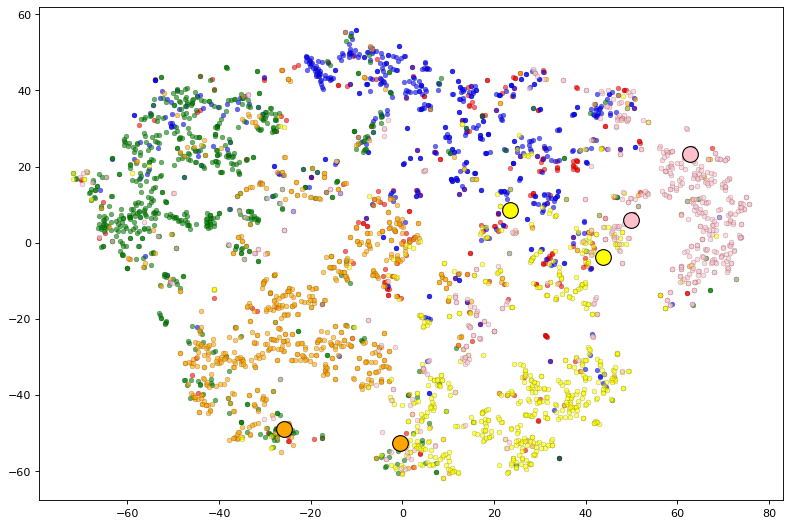

In [65]:
t_sne_embeddings = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(embs)
citeseer_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}
fig = plt.figure(figsize=(12,8), dpi=80)
for class_id in range(dataset.num_classes):
    plt.scatter(t_sne_embeddings[labels == class_id, 0], t_sne_embeddings[labels == class_id, 1], s = 20, color=citeseer_label_to_color_map[class_id], edgecolors='black', linewidths=0.2, alpha = 0.6)

for node, label in zip(minority_nodes, minority_labels):
    plt.scatter(t_sne_embeddings[node, 0], t_sne_embeddings[node, 1], s = 200, color=citeseer_label_to_color_map[label], edgecolors='black', linewidths=1, alpha=1)

plt.show()

In [13]:
# Public split
import numpy as np
import functools

from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import normalize, OneHotEncoder
def repeat(n_times):
    def decorator(f):
        @functools.wraps(f)
        def wrapper(*args, **kwargs):
            results = [f(*args, **kwargs) for _ in range(n_times)]
            statistics = {}
            for key in results[0].keys():
                values = [r[key] for r in results]
                statistics[key] = {
                    'mean': np.mean(values),
                    'std': np.std(values)}
            print_statistics(statistics, f.__name__)
            return statistics
        return wrapper
    return decorator


def prob_to_one_hot(y_pred):
    ret = np.zeros(y_pred.shape, np.bool)
    indices = np.argmax(y_pred, axis=1)
    for i in range(y_pred.shape[0]):
        ret[i][indices[i]] = True
    return ret


def print_statistics(statistics, function_name):
    print(f'(E) | {function_name}:', end=' ')
    for i, key in enumerate(statistics.keys()):
        mean = statistics[key]['mean']
        std = statistics[key]['std']
        print(f'{key}={mean:.4f}+-{std:.4f}', end='')
        if i != len(statistics.keys()) - 1:
            print(',', end=' ')
        else:
            print()


@repeat(3)
def label_classification(embeddings, y, ratio):
    X = embeddings.detach().cpu().numpy()
    Y = y.detach().cpu().numpy()
    Y = Y.reshape(-1, 1)
    onehot_encoder = OneHotEncoder(categories='auto').fit(Y)
    Y = onehot_encoder.transform(Y).toarray().astype(bool)

    X = normalize(X, norm='l2')
    if split == 'random':
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=1 - ratio)
    elif split == 'public':
        train_mask = data.train_mask.detach().cpu()
        test_mask  = data.test_mask.detach().cpu()
        X_train = X[train_mask]
        X_test  = X[test_mask]
        y_train = Y[train_mask]
        y_test  = Y[test_mask]
    elif split == 'imbalance':
        train_mask = data.imb_train_mask
        test_mask  = data.test_mask
        X_train = X[train_mask]
        X_test  = X[test_mask]
        y_train = new_Y[train_mask]
        y_test  = Y[test_mask]

    logreg = LogisticRegression(solver='liblinear')
    c = 2.0 ** np.arange(-10, 10)

    clf = GridSearchCV(estimator=OneVsRestClassifier(logreg),
                       param_grid=dict(estimator__C=c), n_jobs=8, cv=5,
                       verbose=0)
    clf.fit(X_train, y_train)

    y_pred = clf.predict_proba(X_test)
    y_pred = prob_to_one_hot(y_pred)

    micro = f1_score(y_test, y_pred, average="micro")
    macro = f1_score(y_test, y_pred, average="macro")

    return {
        'F1Mi': micro,
        'F1Ma': macro
    }

split = 'public'
z = load_embeddings(osp.join('embeddings', name + '_' + model_name+'.pt'))
label_classification(z, data.y, ratio = 0)

/tmp/ipykernel_4020725/1007173955.py:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ret = np.zeros(y_pred.shape, np.bool)
/tmp/ipykernel_4020725/1007173955.py:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ret = np.zeros(y_pred.shape, np.bool)


(E) | label_classification: F1Mi=0.6790+-0.0000, F1Ma=0.6447+-0.0000


/tmp/ipykernel_4020725/1007173955.py:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ret = np.zeros(y_pred.shape, np.bool)


{'F1Mi': {'mean': 0.6789999999999999, 'std': 1.1102230246251565e-16},
 'F1Ma': {'mean': 0.6447423001009851, 'std': 0.0}}

In [8]:
train_idx = torch.arange(data.num_nodes)[data.train_mask]
train_labels = data.y[data.train_mask]

In [9]:
train_idx

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59])

In [15]:
(train_labels == 3).sum()

tensor(0)